# Initialisation du projet

In [1]:
# bibliotheques mathematiques
import numpy as np

# bibliotheques pour les representations graphiques
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# bibliotheques pour le machine learning
import sklearn.decomposition
import sklearn.svm
import sklearn.neighbors
from sklearn.preprocessing import normalize
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# bibliotheque pour les modèles
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier

# bibliotheques pour le chargement des donnees
import csv
import pandas as pd

plt.ion()

In [2]:
def load_sub_sets(ratio_train, ratio_valid, train_csv, test_csv):
    data_train = np.genfromtxt(train_csv, delimiter=',', skip_header=1) # lecture du fichier train_csv
    y = data_train[:,0]                                                 # les labels
    X = data_train[:,1:]                                                # les donnees (sans leurs labels)
    
    Ntot   = X.shape[0]                                                 # nombre d'images dans les donnees X
    Ntrain = int(ratio_train*Ntot)                                      # nombre d'images pour l'entrainement
    Nvalid = int(ratio_valid*Ntot)                                      # nombre d'images pour la validation
    
    X_train = X[0: Ntrain].copy()                                       # les donnees qu'on utilise pour entrainer les modeles
    y_train = y[0: Ntrain].copy()                                       # les labels associes 
    
    X_valid = X[Ntrain:Ntrain+Nvalid].copy()                            # les donnees qu'on utilise pour tester les modeles
    y_valid = y[Ntrain:Ntrain+Nvalid].copy()                            # les labels associes
        
    data_test = np.genfromtxt(test_csv, delimiter=',', skip_header=1)   # lecture du fichier test_csv
    data_test = data_test[1:]                                           # donnees generales du fichier test_csv (celles que le modele ne connait pas)
    X_test  = data_test[:,1:]                                           # les labels
    y_test  = data_test[:,0]                                            # les donnees (sans leur label)
    
    return X, y, X_train, y_train, X_valid, y_valid, X_test, y_test

In [3]:
dim_repre = 28
ratio_train = 0.7
ratio_valid = 0.3

X, y, X_train, y_train, X_valid, y_valid, X_test, y_test = load_sub_sets(ratio_train, ratio_valid, 'sign_mnist_train.csv', 'sign_mnist_test.csv')

---
# Affichage des données

On affiche quelques données du dataset sous la forme d'images

## 1. Représentation de différentes données

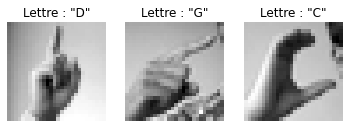

In [4]:
nb_displayed_dataset = 3
fig, ax = plt.subplots(1, nb_displayed_dataset)                         # creation de 3 subplots horizontaux

for i in range(nb_displayed_dataset):
    label_idx = int(y[i])                                               # on récupère l'indice alphabetique lié à la donnée
    letter_rep = chr(ord('A') + label_idx)                              # on transforme l'indice en lettre (eg. indice 0 devient 'A')
    ax[i].set_axis_off()                                                # on cache les axes
    ax[i].set_title(f'Lettre : "{letter_rep}"')                         # on affiche la lettre dans le titre
    ax[i].imshow(X[i].reshape(dim_repre, dim_repre), cm.gray)           # on affiche l'image sous la forme de nuance de gris en
                                                                        #  transformant la matrice linéaire en matrice carré

## 2. Différentes représentations d'un même label

In [5]:
selected_label_idx = 0                                                  # on choisi d'afficher différentes représentations d'une lettre
selected_letter = chr(ord('A') + selected_label_idx)                    # la lettre selectionnée
only_A = (selected_label_idx == y)                                      # on créé un mask qui filtre les données qui représente notre lettre sélectionnée
X_of_A = X[only_A]                                                      # on applique notre masque
print(f'Nous avons trouvés {X_of_A.shape[0]} représentations de la lettre {selected_letter}.')

Nous avons trouvés 1126 représentations de la lettre A.


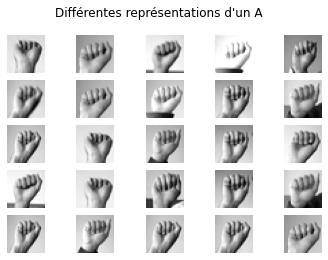

In [6]:
nb_subplots_by_ax = 5
fig, ax = plt.subplots(nb_subplots_by_ax, nb_subplots_by_ax)            # creation des subplots

fig.suptitle(f'Différentes représentations d\'un {selected_letter}')
for i in range(nb_subplots_by_ax):
    for j in range(nb_subplots_by_ax):
        idx = i*nb_subplots_by_ax + j                                   # on transforme le couple (i,j) en l'indice de l'image
        img = X_of_A[idx].reshape(dim_repre, dim_repre)                 # transformation de la matrice linéaire en matrice carré
        ax[i,j].set_axis_off()                                          # on cache les axes
        ax[i,j].imshow(img, cm.gray)                                    # on affiche l'image sous la forme de nuance de gris

---

# Préprocessing
Sélection du meilleur nombre de composants

In [7]:
class CompRanker:
    def __init__(self, n):
        self.n_comps_score = [0 for i in range(n)]
        
    def update_rank(self, data, reverse=False):
        for i, x in enumerate(data):
            self.n_comps_score[i] += -x if reverse else x

    def get_best_n_comps(self, nb_comp_range):
        """lettres = [(0, 234), (1, 100), (2, 400)]
        sorted(lettres, key=lambda x: x[1])
        [(2, 400), (0, 234), (1, 100)]
        """
        scores = sorted(enumerate(self.n_comps_score), key=lambda x: x[1], reverse=True)
        formated_ranks = [(nb_comp_range[i], score) for i, score in scores]
        return tuple(zip(*formated_ranks))

In [8]:
def get_scores_for_nb_comp_range(nb_comp_range):
    training_scores = []                                                # tableau des scores d'entrainement en fonction du nombre de composants séléctionné
    valid_scores = []                                                   # tableau des scores de validation en fonction du nombre de composants séléctionné
    tab_result = pd.DataFrame(columns=[
        'score d\'entrainement',
        'score de validation',
        'différence'])                                                  # tableau récapitulatif

    for nb_comp in nb_comp_range:
        print(f'Récupération du score pour une PCA de {nb_comp} composants...')
        pre_proc = sklearn.decomposition.PCA(n_components=nb_comp)      # création d'un PCA permettant la compression des images en nb_comp pixels
        pre_proc.fit(X)                                                 # entrainement du modèle PCA
        X_train_transformed = pre_proc.transform(X_train)               # transformation des données d'entrainement en fonction du PCA
        X_valid_transformed = pre_proc.transform(X_valid)               # transformation des données de validation en fonction du PCA

        clf = sklearn.svm.SVC(kernel='poly', coef0=1, degree=2)         # on choisit un classifieur SVC
        clf.fit(X_train_transformed, y_train)                           # on entraine notre classifieur avec X_train_transformed

        train_score = clf.score(X_train_transformed, y_train)           # on récupère les scores liés (entrainement)
        valid_score = clf.score(X_valid_transformed, y_valid)           # on récupère les scores liés (validation)

        tab_result.loc[f'{nb_comp} composants'] = np.array([
            f'{train_score * 100:.2f}%',
            f'{valid_score * 100:.2f}%',
            f'{(train_score-valid_score) * 100:.2f}%'])                 # ajout des données dans le tableau récapitulatif (en pourcentage)

        training_scores.append(train_score * 100)                       # on sauvegarde les scores d'entrainement pour les statistiques
        valid_scores.append(valid_score * 100)                          # on sauvegarde les scores de validation pour les statistiques

    return np.array(training_scores), np.array(valid_scores), tab_result

In [9]:
def plot_best_scores(comp_ranker, nb_comp_range, training_scores, valid_scores):
    plt.title('Évolution du score en fonction du nombre de composants')
    plt.plot(nb_comp_range, training_scores, label='train score')
    plt.plot(nb_comp_range, valid_scores, label='valid score')
    plt.xlabel('nombre de composants')
    plt.ylabel('scores (%)')
    plt.legend()

    best_index = np.argmax(training_scores)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, training_scores[best_index], marker='X', color='red')

    print(f'Meilleur nombre de composants pour maximiser le score : {best_n_comp}\n')
    comp_ranker.update_rank(training_scores)

In [10]:
def plot_less_overfitting(comp_ranker, nb_comp_range, training_scores, valid_scores):
    diff_scores = training_scores - valid_scores

    plt.title('Évolution de l\'overfitting en fonction du nombre de composants')
    plt.plot(nb_comp_range, diff_scores)
    plt.xlabel('nombre de composants')
    plt.ylabel('différence (%)')

    best_index = np.argmin(diff_scores)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, diff_scores[best_index], marker='X', color='red')

    print(f'Meilleur nombre de composants pour minimiser l\'overfitting : {best_n_comp}\n')

    comp_ranker.update_rank(diff_scores, reverse=True)

In [11]:
def plot_best_incr_scores(comp_ranker, nb_comp_range, training_scores, valid_scores):
    training_scores_incr = np.array([
        score - training_scores[i-1] if i != 0 else 0
        for i, score in enumerate(training_scores)])
    valid_scores_incr = np.array([
        score - valid_scores[i-1] if i != 0 else 0
        for i, score in enumerate(valid_scores)])

    plt.title('Évolution de l\'accroissement du score en fonction du nombre de composants')
    plt.plot(nb_comp_range, training_scores_incr, label='train score')
    plt.plot(nb_comp_range, valid_scores_incr, label='valid score')
    plt.xlabel('nombre de composants')
    plt.ylabel('accroissement du score (%)')
    plt.legend()

    best_index = np.argmax(training_scores_incr)
    best_n_comp = nb_comp_range[best_index]
    plt.plot(best_n_comp, training_scores_incr[best_index], marker='X', color='red')

    print(f'Meilleur nombre de composants pour maximiser le gain de score : {best_n_comp}\n')

    comp_ranker.update_rank(valid_scores_incr)

In [12]:
def get_best_np_comp(comp_ranker, nb_comp_range):
    x_nb_comp, y_score = comp_ranker.get_best_n_comps(nb_comp_range)

    plt.title('Évaluation du meilleur nombre de composants\nen fonction du score moyen')
    plt.bar(x_nb_comp, y_score, width=1)
    plt.xlabel('nombre de composants')
    plt.ylabel('score moyen')

    best_nb_comp, best_score = -1, -1
    for nb_comp, score in zip(x_nb_comp, y_score):
        if score > best_score:
            best_nb_comp = nb_comp
            best_score = score

    plt.plot(best_nb_comp, best_score, marker='X', color='red')
    print(f'Meilleur nombre de composants : {best_nb_comp}\n')

    return best_nb_comp    

## 1. Première sélection (sélection large)

In [13]:
s1_nb_steps = 5
s1_incr = 10
s1_min = 1
s1_max = s1_min + s1_nb_steps * s1_incr
s1_nb_comp_range = np.arange(s1_min, s1_max, s1_incr)

In [14]:
s1_training_scores, s1_valid_scores, s1_tab = get_scores_for_nb_comp_range(s1_nb_comp_range)

Récupération du score pour une PCA de 1 composants...
Récupération du score pour une PCA de 11 composants...
Récupération du score pour une PCA de 21 composants...
Récupération du score pour une PCA de 31 composants...
Récupération du score pour une PCA de 41 composants...


In [15]:
s1_n = len(s1_training_scores)
s1_comp_ranker = CompRanker(s1_n)
s1_tab

,score d'entrainement,score de validation,différence
1 composants,6.97%,6.88%,0.08%
11 composants,84.26%,83.39%,0.87%
21 composants,97.94%,97.80%,0.14%
31 composants,99.23%,99.14%,0.09%
41 composants,99.89%,99.84%,0.05%


Meilleur nombre de composants pour maximiser le score : 41



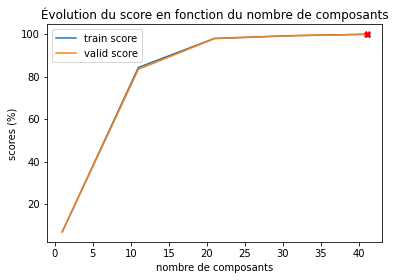

In [16]:
plot_best_scores(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 41



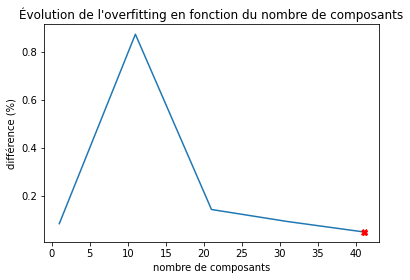

In [17]:
plot_less_overfitting(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

Meilleur nombre de composants pour maximiser le gain de score : 11



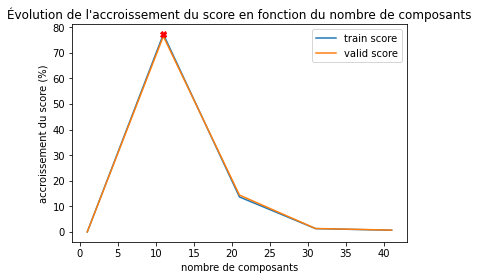

In [18]:
plot_best_incr_scores(s1_comp_ranker, s1_nb_comp_range, s1_training_scores, s1_valid_scores)

Meilleur nombre de composants : 11



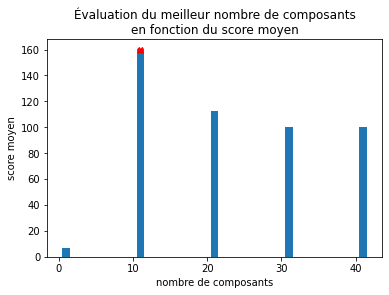

In [19]:
s1_best_nb_comp = get_best_np_comp(s1_comp_ranker, s1_nb_comp_range)

## 2. Deuxième sélection (sélection moyenne)

In [20]:
s2_nb_steps = 3
s2_incr = 3
s2_min = s1_best_nb_comp - int(s2_nb_steps/2)     * s2_incr
s2_max = s1_best_nb_comp + (1+int(s2_nb_steps/2)) * s2_incr
s2_nb_comp_range = np.arange(s2_min, s2_max, s2_incr)

In [21]:
s2_training_scores, s2_valid_scores, s2_tab = get_scores_for_nb_comp_range(s2_nb_comp_range)

Récupération du score pour une PCA de 8 composants...
Récupération du score pour une PCA de 11 composants...
Récupération du score pour une PCA de 14 composants...


In [22]:
s2_n = len(s2_training_scores)
s2_comp_ranker = CompRanker(s2_n)
s2_tab

,score d'entrainement,score de validation,différence
8 composants,69.39%,67.88%,1.50%
11 composants,84.27%,83.39%,0.88%
14 composants,91.93%,91.77%,0.17%


Meilleur nombre de composants pour maximiser le score : 14



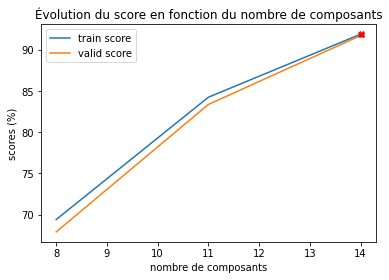

In [23]:
plot_best_scores(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 14



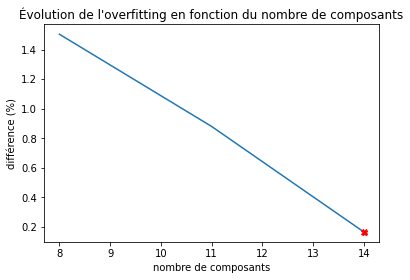

In [24]:
plot_less_overfitting(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

Meilleur nombre de composants pour maximiser le gain de score : 11



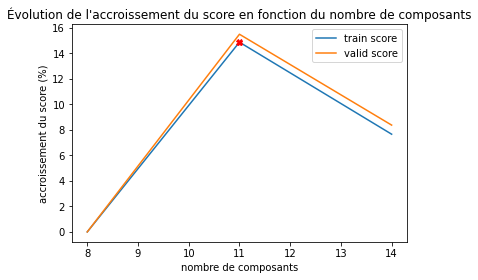

In [25]:
plot_best_incr_scores(s2_comp_ranker, s2_nb_comp_range, s2_training_scores, s2_valid_scores)

Meilleur nombre de composants : 14



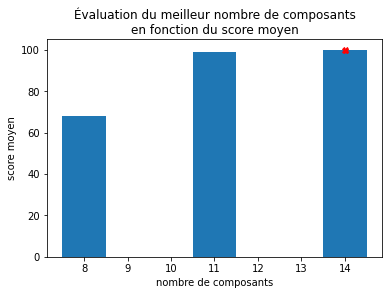

In [26]:
s2_best_nb_comp = get_best_np_comp(s2_comp_ranker, s2_nb_comp_range)

## 3. Troisième sélection (sélection étroite)

In [27]:
s3_nb_steps = 3
s3_incr = 1
s3_min = s2_best_nb_comp - int(s3_nb_steps/2)     * s3_incr
s3_max = s2_best_nb_comp + (1+int(s3_nb_steps/2)) * s3_incr
s3_nb_comp_range = np.arange(s3_min, s3_max, s3_incr)

In [28]:
s3_training_scores, s3_valid_scores, s3_tab = get_scores_for_nb_comp_range(s3_nb_comp_range)

Récupération du score pour une PCA de 13 composants...
Récupération du score pour une PCA de 14 composants...
Récupération du score pour une PCA de 15 composants...


In [29]:
s3_n = len(s3_training_scores)
s3_comp_ranker = CompRanker(s3_n)
s3_tab

,score d'entrainement,score de validation,différence
13 composants,90.52%,90.25%,0.27%
14 composants,91.93%,91.77%,0.17%
15 composants,94.04%,93.78%,0.25%


Meilleur nombre de composants pour maximiser le score : 15



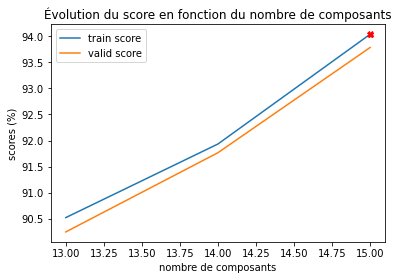

In [30]:
plot_best_scores(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

Meilleur nombre de composants pour minimiser l'overfitting : 14



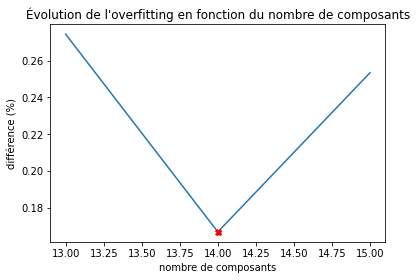

In [31]:
plot_less_overfitting(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

Meilleur nombre de composants pour maximiser le gain de score : 15



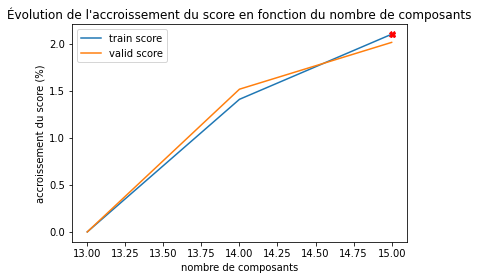

In [32]:
plot_best_incr_scores(s3_comp_ranker, s3_nb_comp_range, s3_training_scores, s3_valid_scores)

Meilleur nombre de composants : 15



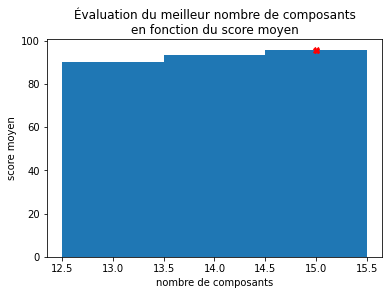

In [33]:
s3_best_nb_comp = get_best_np_comp(s3_comp_ranker, s3_nb_comp_range)

## 4. Conclusion

In [34]:
best_nb_comp = s3_best_nb_comp
pre_proc = sklearn.decomposition.PCA(n_components=best_nb_comp)
pre_proc.fit(X)

X_train_transformed = pre_proc.transform(X_train)
X_valid_transformed = pre_proc.transform(X_valid)
X_test_transformed = pre_proc.transform(X_test)

print(f'Le meilleur nombre de composant pour la PCA : {best_nb_comp}')

Le meilleur nombre de composant pour la PCA : 15


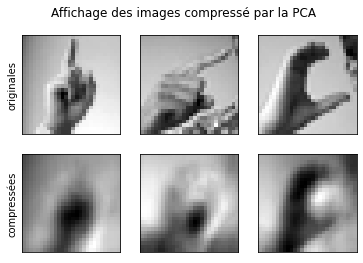

In [35]:
nb_pictures = 3
fig, ax = plt.subplots(2, nb_pictures)

fig.suptitle(f'Affichage des images compressé par la PCA')

for i in range(nb_pictures):
    img = X_train[i].reshape(dim_repre, dim_repre)
    inverse_transformed_img = pre_proc.inverse_transform(X_train_transformed[i])
    compressed_img = inverse_transformed_img.reshape(dim_repre, dim_repre)
    if i == 0:
        ax[0,i].set_ylabel('originales')
        ax[1,i].set_ylabel('compressées')
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    ax[0,i].imshow(img, cm.gray)
    ax[1,i].imshow(compressed_img, cm.gray)

# Modèle
## Sélection du meilleur modèle

In [36]:
model_dict = dict(Svc=SVC(),
                  NuSvc=NuSVC(),
                  DecisionTree=DecisionTreeClassifier())

In [37]:
def analyze_model_experiments(tab_result):
    med_score_validation = tab_result.Score_validation.median()
    med_score_training = tab_result.Score_training.median()
    valid_bad = tab_result.Score_validation < med_score_validation      # On regarde si le score de validation est mauvais 
    train_bad = tab_result.Score_training < med_score_training          # On regarde si le score d'entrainement est mauvais
    overfitted = valid_bad & ~train_bad                                 # Si c'est le cas seulement pour la validation alors on est en overfitting        
    underfitted = valid_bad & train_bad                                 # Si c'est le cas pour les deux alors on est en underfitting
    tab_result['Overfitted'] = overfitted
    tab_result['Underfitted'] = underfitted
    return tab_result

def performance(X_train, Y_train, X_valid, Y_valid, model_dict):
    tab_result = pd.DataFrame(columns=["CVScore",                       # On créé un tableau panda
                                       "(+/-)",
                                       "Score_training",
                                       "Score_validation"])  
    for model_name, model in model_dict.items():                        # On itère sur chaque modèle du dictionnaire
        model.fit(X_train, Y_train)                                     # On entraine le modèle sur l'ensemble d'entrainement
        CVScore = cross_val_score(model, X_train, Y_train, cv=5)        # On calcul la cross validation
        train_score = model.score(X_train, Y_train)                     # On calcul le score sur l'ensemble d'entrainement
        valid_score = model.score(X_valid, Y_valid)                     # On calcul le score sur l'ensemble de validation
        tab_result.loc[model_name] = np.array([CVScore.mean(),          # On ajoute les scores dans le tableau
                                               CVScore.std() * 2,
                                               train_score,
                                               valid_score])
    return tab_result

In [38]:
compar_results = performance(X_train_transformed,                       # Appel de la fonction "performance" avec nos données transformées
                             y_train,
                             X_valid_transformed,
                             y_valid,
                             model_dict)
compar_results.round(6).style.background_gradient(cmap='Blues')
best_model = compar_results.Score_validation.idxmax()                   # On cherche ici le meilleur modèle
print("Le meilleur modèle est : {}".format(best_model))

analyze_model_experiments(compar_results)                               # On affiche le tableau des résultats

Le meilleur modèle est : DecisionTree


,CVScore,(+/-),Score_training,Score_validation,Overfitted,Underfitted
Svc,0.916224,0.005426,0.941253,0.933341,False,False
NuSvc,0.781819,0.010611,0.800239,0.790432,False,True
DecisionTree,0.924654,0.006272,1.000000,0.935163,False,False


## Sélection des hyper-paramètres

In [39]:
svc = SVC(kernel='poly')                                                # On initialise notre meilleur modèle
distributions = dict(degree=[2, 3],                                     # On créé un dictionnaire d'hyper-paramètres de ce modèle
                     coef0=[0.0, 2.0, 3.0],
                     gamma=['scale', 'auto'])
clf = RandomizedSearchCV(svc, distributions)                            # On apelle RandomeSearchCV qui va nous renvoyer le modèle avec les hyper-paramètres les plus optimisé
search = clf.fit(X_train_transformed, y_train)                          # On entraine notre modèle avec l'ensemble d'entrainement

print("Score final : ", search.score(X_valid_transformed, y_valid))     # On affiche le score obtenu avec l'ensemble de validation
print("Meilleurs parametres : ", search.best_params_)                   # On affiche les meilleurs hyper-paramètres
print("Meilleure configuration : ", search.best_estimator_)             # On affiche la configuration du modèle optimale

Score final :  0.9991500728508985
Meilleurs parametres :  {'gamma': 'auto', 'degree': 2, 'coef0': 0.0}
Meilleure configuration :  SVC(degree=2, gamma='auto', kernel='poly')


# Test final

In [40]:
X_test_transformed = pre_proc.transform(X_test)
svc = SVC()
svc.fit(X_train_transformed, y_train)
print("Score de l'ensemble test : ", svc.score(X_test_transformed, y_test))

Score de l'ensemble test :  0.7767396457955654


### on prepare nos données

In [41]:
nbCompOptimal = 16
#car bon score + plafone un peu après + nombre de composants le plus limités possible

In [42]:
#on prépare nos données en les optimisants

preProc = sklearn.decomposition.PCA(n_components = nbCompOptimal)
preProc.fit(X)

X_train_transformed = pre_procrain)
X_valid_transformed = preProcpreProcpre_procalid)

X_train_decompressees = preProc.inverse_transform(X_train_transformed)

SyntaxError: unmatched ')' (<ipython-input-42-e97e82c0aac0>, line 6)

In [ ]:
plt.figure()
plt.imshow(X_train_decompressees[idx].reshape(dimRepre, dimRepre), cm.gray)

### comparaison pour une autre svm : LinearSVC

In [ ]:
clfLinearSVC = sklearn.svm.LinearSVC()
clfLinearSVC.fit(normalize(X_train_transformed), y_train)

trainscore = clfLinearSVC.score(X_train_transformed, y_train)
validscore = clfLinearSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", str(nbCompOptimal) , "   training score:",trainscore, ". valid score:", validscore)

##### on teste le modele LinearSVC sans PCA

In [ ]:
clfLinearSVC2 = sklearn.svm.LinearSVC()
clfLinearSVC2.fit(normalize(X_train), y_train)

trainscore = clfLinearSVC2.score(X_train, y_train)
validscore = clfLinearSVC2.score(X_valid, y_valid)
print("training score:",trainscore, ". valid score:", validscore)

##### on teste le modele LinearSVC avec PCA avec beaucoup de composants

In [ ]:
#compression des images en n_components pixels
preProc3 = sklearn.decomposition.PCA(n_components = 700)
#entrainement
preProc3.fit(X)
#X_train_transformed = les donnees de X_train entraines, idem pour X_valid_transformed
X_train_transformed3 = preProc.transform(X_train)
X_valid_transformed3 = preProc.transform(X_valid)

In [ ]:
clfLinearSVC3 = sklearn.svm.LinearSVC()
clfLinearSVC3.fit(normalize(X_train_transformed3), y_train)

trainscore = clfLinearSVC3.score(X_train_transformed3, y_train)
validscore = clfLinearSVC3.score(X_valid_transformed3, y_valid)
print("nombre Composants", str(700) , "   training score:",trainscore, ". valid score:", validscore)

## Comparaison SVC (avec kernel linéaire)

In [ ]:
clfLinearSVC =sklearn.svm.SVC(C =1, kernel = 'linear', coef0 = 1)
clfLinearSVC.fit(normalize(X_train_transformed), y_train)

trainscore = clfLinearSVC.score(X_train_transformed, y_train)
validscore = clfLinearSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", str(nbCompOptimal) , "   training score:",trainscore, ". valid score:", validscore)

### comparaison pour une autre svm : NuSVC

In [ ]:
clfNuSVC = sklearn.svm.NuSVC(nu=0.7, kernel='poly', coef0=1, degree=2)
clfNuSVC.fit(X_train_transformed, y_train)

trainscore = clfNuSVC.score(X_train_transformed, y_train)
validscore = clfNuSVC.score(X_valid_transformed, y_valid)
print("nombre Composants", str(nbCompOptimal) , "   training score:",trainscore, ". valid score:", validscore)

##### on teste le modele NuSVC sans PCA

In [ ]:
clfNuSVC2 = sklearn.svm.NuSVC(nu=0.7, kernel='poly', coef0=1, degree=2)
clfNuSVC2.fit(X_train, y_train)

trainscore = clfNuSVC2.score(X_train, y_train)
validscore = clfNuSVC2.score(X_valid, y_valid)
print("training score:",trainscore, ". valid score:", validscore)

### cross-validation

In [ ]:
num_folds = 10
kfold = sklearn.model_selection.KFold(n_splits=num_folds)
kfold

In [ ]:
monScoring = sklearn.model_selection.cross_val_score(estimator = clf, X = X, y = y, cv= kfold, scoring= 'neg_mean_squared_error')